# [CSCI 3397/PSYC 3317] Lab 2: More about Filtering

**Posted:** Saturday, February 3, 2024

**Due:** Friday, February 9, 2023

__Total Points__: 8 pts

__Submission__: please rename the .ipynb file as __\<your_username\>_lab2.ipynb__ before you submit it to canvas. Example: weidf_lab2.ipynb.

In [1]:
from imageio import imread, imwrite
import numpy as np
import matplotlib.pyplot as plt


# download image
! wget https://bc-cv.github.io/csci3397/public/dip_feature/cell_canny_im.png -O cell_canny_im.png
! wget https://bc-cv.github.io/csci3397/public/bc_eagle.png -O bc_eagle.png
! wget https://bc-cv.github.io/csci3397/public/dip_pixel/xray_image.png -O xray_image.png

! wget https://bc-cv.github.io/csci3397/public/dip_feature/einstein.png -O einstein.png
! wget https://bc-cv.github.io/csci3397/public/dip_preprocess/brightfield_bacteria.jpg -O brightfield_bacteria.jpg

--2025-07-17 04:00:35--  https://bc-cv.github.io/csci3397/public/dip_feature/cell_canny_im.png
Resolving bc-cv.github.io (bc-cv.github.io)... 185.199.110.153, 185.199.109.153, 185.199.111.153, ...
Connecting to bc-cv.github.io (bc-cv.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112070 (109K) [image/png]
Saving to: ‘cell_canny_im.png’

cell_canny_im.png   100%[===================>] 109.44K  --.-KB/s    in 0.01s   

2025-07-17 04:00:35 (7.15 MB/s) - ‘cell_canny_im.png’ saved [112070/112070]

--2025-07-17 04:00:35--  https://bc-cv.github.io/csci3397/public/bc_eagle.png
Resolving bc-cv.github.io (bc-cv.github.io)... 185.199.110.153, 185.199.109.153, 185.199.111.153, ...
Connecting to bc-cv.github.io (bc-cv.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21473 (21K) [image/png]
Saving to: ‘bc_eagle.png’

bc_eagle.png        100%[===================>]  20.97K  --.-KB/s    in 0.002s  


# <b>0. OpenCV package</b>

## 0.1 Image Basics
Things are the same for grayscale images. <b>BUT FOR COLOR IMAGES</b>, opencv reads in the BGR order instead of RGB... Need to use `cv2_imshow` to display the image properly. Thus, in this course, we'll use `imageio.imread` instead.

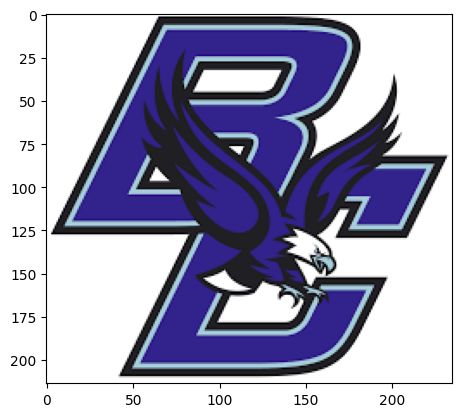

In [2]:
import cv2
import matplotlib.pyplot as plt
# read in BGR instead of RGB
I = cv2.imread('bc_eagle.png')
plt.imshow(I)

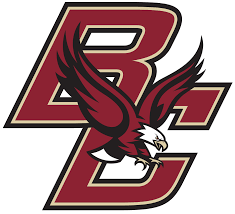

In [3]:
from google.colab.patches import cv2_imshow
cv2_imshow(I)

## 0.2 Pixel-level processing

We can directly use the histogram equalization function.
https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html

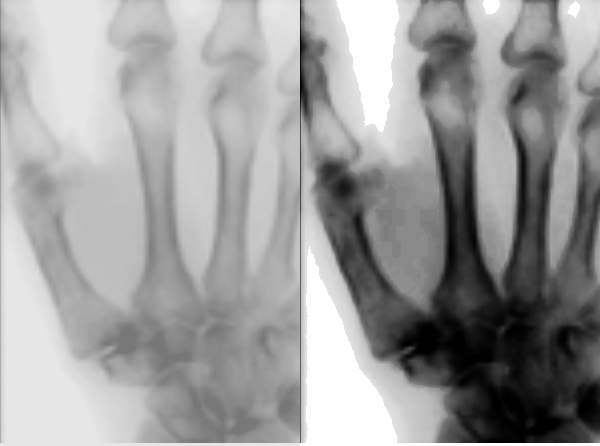

In [4]:
img = cv2.imread('xray_image.png',0)
equ = cv2.equalizeHist(img)
res = np.hstack((img,equ)) #stacking images side-by-side
cv2_imshow(res)

## 0.3 Patch-level processing
As you now have the hand-on knowledge of convolution, we will directly use OpenCV functions to implement filtering. From now on, you can focus on learning how to use these filters to solve real-world problems.

Syntax:
- Generic filter: `cv2.filter2D(image, -1, kernel matrix)`
- Gaussian: `cv2.GaussianBlur(image, kernel_size, sigma_x, sigma_y)` (if sigma_x=0, it'll be automatically estimated)

[[Tutorial]](https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html)

box vs. Gaussian filter


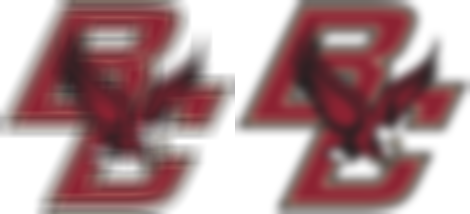

vertical vs. horizontal motion blur


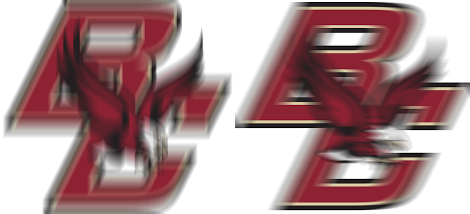

In [5]:

kernel_size = 21
sigma = 5

# Box filter
# note the grid ghosting artifacts
I_box = cv2.filter2D(I, -1, np.ones([kernel_size,kernel_size])/(kernel_size**2))

# Gaussian filter
I_gauss = cv2.GaussianBlur(I, (kernel_size,kernel_size), sigma)

# motion blur filter
# 1D version of box filter, as if the object moves really fast in one direction
I_hblur = cv2.filter2D(I, -1, np.ones([1,kernel_size])/kernel_size)
I_vblur = cv2.filter2D(I, -1, np.ones([kernel_size,1])/kernel_size)


print('box vs. Gaussian filter')
cv2_imshow(np.hstack([I_box,I_gauss]))

print('vertical vs. horizontal motion blur')
cv2_imshow(np.hstack([I_vblur,I_hblur]))

# <b>Lec. 7: More Linear Filtering</b>

## 1.1 Gaussian Filter

### 1D Gaussian: mean and standard deviation
 Lec 3, page 10

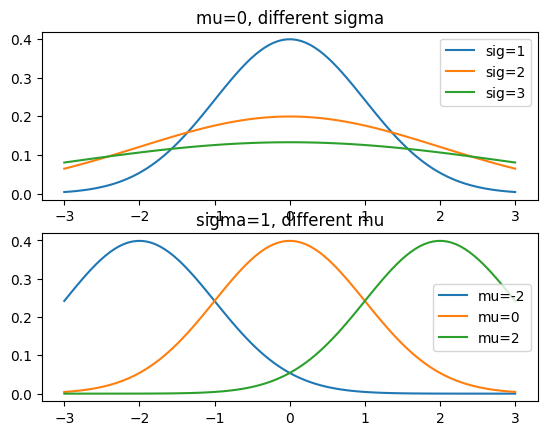

In [6]:
from matplotlib import pyplot as plt
import numpy as np


def gaussian(x, mu, sig):
    return (
        1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    )


x_values = np.linspace(-3, 3, 100)
plt.subplot(211)
mu=0
for sig in [1,2,3]:
    plt.plot(x_values, gaussian(x_values, mu, sig))
plt.legend(['sig=1','sig=2','sig=3'])
plt.title('mu=0, different sigma')

plt.subplot(212)
sig=1
for mu in [-2, 0, 2]:
    plt.plot(x_values, gaussian(x_values, mu, sig))
plt.legend(['mu=-2','mu=0','mu=2'])
plt.title('sigma=1, different mu')
plt.show()

### Recursive nature
 Lec 3, page 13-14

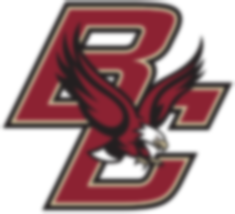

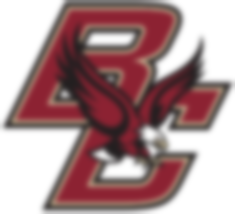

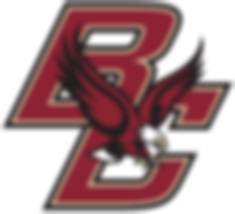

In [7]:
I = cv2.imread('bc_eagle.png')

kernel_size = 11
sigma = 2
I_gauss_1 = cv2.GaussianBlur(I, (kernel_size,kernel_size), sigma)
I_gauss_2 = cv2.GaussianBlur(I_gauss_1, (kernel_size,kernel_size), sigma)
I_gauss_sqrt2 = cv2.GaussianBlur(I, (kernel_size,kernel_size), sigma * np.sqrt(2))


cv2_imshow(I_gauss_1)
cv2_imshow(I_gauss_2)
cv2_imshow(I_gauss_sqrt2)

### Separable nature
 Lec 3, page 15

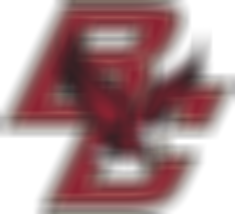

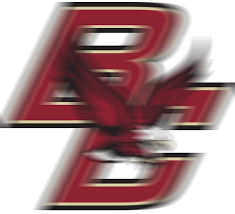

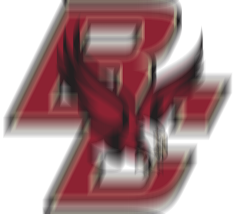

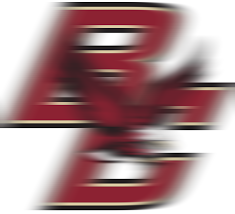

In [8]:
kernel_size = 21
sigma = 110

I_gauss_1 = cv2.GaussianBlur(I, (kernel_size,kernel_size), sigma)

I_gauss_h = cv2.GaussianBlur(I, (kernel_size,1), sigma)
I_gauss_v = cv2.GaussianBlur(I, (1,kernel_size), sigma)

I_gauss_hv = cv2.GaussianBlur(I_gauss_h, (kernel_size,1), sigma)

cv2_imshow(I_gauss_1)
cv2_imshow(I_gauss_h)
cv2_imshow(I_gauss_v)
cv2_imshow(I_gauss_hv)

## 1.2 Edge Filter
Lec. 7, page 20-21

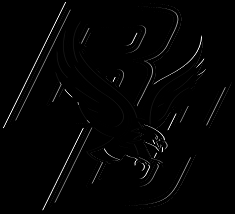

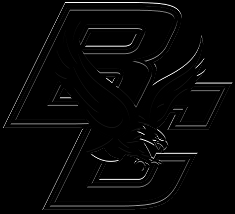

In [9]:
# direct difference filter: [1, -1]
kernel_diff = np.array([1,-1])

# compute the edge on the 0-th channel
Iy = cv2.filter2D(I[:,:,0], -1, kernel_diff)
Ix = cv2.filter2D(I[:,:,0], -1, kernel_diff.reshape([1,2]))
cv2_imshow(Ix)
cv2_imshow(Iy)

# <b>Lec. 8: Gaussian Derivative + Nonlinear Filtering</b>

## 2.1 Gaussian Derivative Filter

Convolve with Gaussian derivative (GD) filter.

(Lec. 8, slide 8)


/tmp/ipython-input-10-2784278688.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I_cell = imread('cell_canny_im.png')


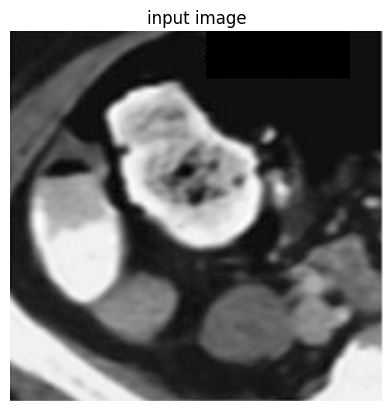

In [10]:
# load input image
I_cell = imread('cell_canny_im.png')
plt.imshow(I_cell, cmap='gray')
plt.axis('off')
plt.title('input image');

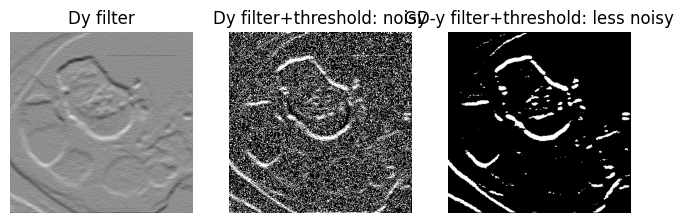

In [11]:
from imageio import imread
import matplotlib.pyplot as plt
import cv2

I_cell2 = I_cell[::2,::2]
I_cell2 = np.clip(I_cell2.astype(float)  +  20 * np.random.random(I_cell2.shape),0,255)

# direct difference filter: [1, -1]
kernel_diff = np.array([1,-1])
Iy = cv2.filter2D(I_cell2, -1, kernel_diff)
Ix = cv2.filter2D(I_cell2, -1, kernel_diff.reshape([1,2]))

# GD filter
kernel_size = 5
I_guass = cv2.GaussianBlur(I_cell2, [kernel_size,kernel_size], 0)
Iy_GD = cv2.filter2D(I_guass, -1, kernel_diff)
Ix_GD = cv2.filter2D(I_guass, -1, kernel_diff.reshape([1,2]))

# show the image
plt.figure(figsize=(8, 8))
# show the pixel value histogram
plt.subplot(131)
plt.imshow(Iy, cmap='gray')
plt.axis('off')
plt.title('Dy filter')

plt.subplot(132)
plt.imshow(np.abs(Iy) > 10, cmap='gray')
plt.axis('off')
plt.title('Dy filter+threshold: noisy')

plt.subplot(133)
plt.imshow(np.abs(Iy_GD)>10, cmap='gray')
plt.axis('off')
plt.title('GD-y filter+threshold: less noisy')


plt.show()

## 2.2 Adaptive Gaussian Thresholding

See exercise (1).

## 2.3 Match Filter

Lec. 8, page 16-18

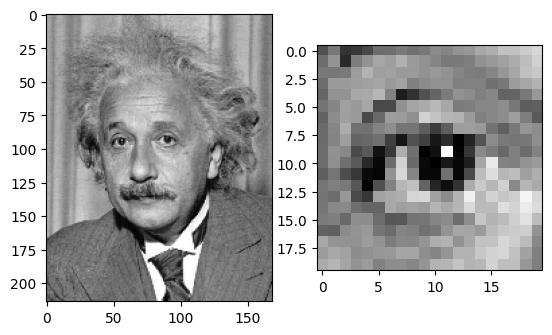

In [12]:
I_einstein = cv2.imread('einstein.png',0)
I_eye = I_einstein[85:105,45:65]
plt.subplot(121)
plt.imshow(I_einstein, cmap='gray')
plt.subplot(122)
plt.imshow(I_eye, cmap='gray')
plt.show()

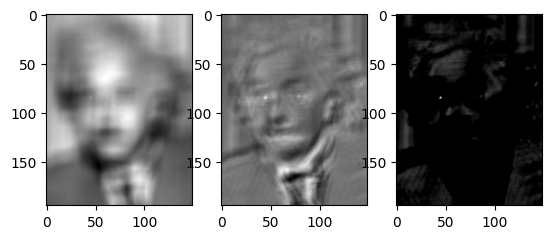

In [21]:
result_cc = cv2.matchTemplate(I_einstein, I_eye, cv2.TM_CCORR)

result_cc_mean0 = cv2.matchTemplate(I_einstein-I_einstein.mean().astype(np.float32), \
                                    I_eye-I_eye.mean().astype(np.float32), cv2.TM_CCORR)

result_ncc = cv2.matchTemplate(I_einstein, I_eye, cv2.TM_CCORR_NORMED)


plt.subplot(131)
plt.imshow(result_cc, cmap='gray')
plt.subplot(132)
plt.imshow(result_cc_mean0, cmap='gray')
plt.subplot(133)
plt.imshow(result_ncc, cmap='gray',vmin=0.94, vmax=1)
plt.show()


In [22]:
result_ncc

array([[0.93940187, 0.93870306, 0.93851465, ..., 0.9222938 , 0.92512184,
        0.92774075],
       [0.9379172 , 0.93787843, 0.93768847, ..., 0.9225635 , 0.9251353 ,
        0.9275848 ],
       [0.9369823 , 0.9366847 , 0.93697065, ..., 0.9225394 , 0.92530376,
        0.9278401 ],
       ...,
       [0.94150496, 0.940934  , 0.93685234, ..., 0.93692285, 0.9311074 ,
        0.92900616],
       [0.940801  , 0.94195485, 0.9407048 , ..., 0.9305959 , 0.9286065 ,
        0.9284958 ],
       [0.9395589 , 0.94077986, 0.9417443 , ..., 0.9318639 , 0.92969346,
        0.9289481 ]], dtype=float32)

# [11 pts] Exercise

## (1) [2 pts] Sharpen filter with paramter $\alpha$

Implement the sharpen filter with OpenCV. i.e., only need to code up the filter kernel and use `cv2.filter2D`. The sharpen kernel in the lecture note sets $\alpha=1$.

Lec 7, page 7

In [14]:
im_xray = imread('xray_image.png')

kernel_size = 3


### Your code starts here
im_xray_sharpen_alpha_1 = ???
im_xray_sharpen_alpha_2 = ???
### Your code ends here

plt.figure(figsize=(18, 8))

plt.subplot(221)
plt.imshow(im_xray, cmap='gray')
plt.title('original image')
plt.subplot(222)
plt.imshow(im_xray_sharpen_alpha_1, cmap='gray')
plt.title('alpha=1')
plt.subplot(223)
plt.imshow(im_xray_sharpen_alpha_2, cmap='gray')
plt.title('alpha=2')

SyntaxError: invalid syntax (ipython-input-14-2441103831.py, line 7)

In [23]:
im_xray.max()

NameError: name 'im_xray' is not defined

## (2) [3 pts] Canny Edge

Find an online opencv tutorial on how to apply canny edge detection and generate the result.


In [ ]:
im_grace = imread('cell_canny_im.png')

### Your code starts here
im_grace_canny =
### Your code ends here

plt.figure(figsize=(18, 8))

plt.subplot(121)
plt.imshow(im_grace, cmap='gray')
plt.title('original image')
plt.subplot(122)
plt.imshow(im_grace_canny, cmap='gray')
plt.title('canny edge detection results')

## (3) [3 pts] Adaptive Gaussian Thresholding

Implement the algorithm described in Lec. 8, page 12-14 (not using `cv2.adaptiveThreshold` function).

In [ ]:
from imageio import imread,imsave
import matplotlib.pyplot as plt

I_bacteria = imread('brightfield_bacteria.jpg')



# 1. brightness estimation
# hint: use a big blur kernel
kernel_size = ???
I_bacteria_blur = ???
# 2. recover original image
I_bacteria_out = ???
# 3. auto-contrast into 0-255 image
I_bacteria_out = ???


plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.imshow(I_bacteria, cmap='gray')
plt.axis('off')
plt.subplot(222)
plt.imshow(I_bacteria_blur, cmap='gray')
plt.axis('off')
plt.subplot(223)
plt.imshow(I_bacteria_out, cmap='gray')
plt.axis('off')
